# 1 Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
import sklearn

digits = load_digits()

# print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

mask17 = np.logical_or(target == 1, target == 7)

data17 = data[mask17]
target17 = target[mask17]
images17 = images[mask17]

n = mask17.sum() // 5

train_data = data17[:3*n]
train_target = target17[:3*n]

test_data = data17[3*n:]
test_target = target17[3*n:]

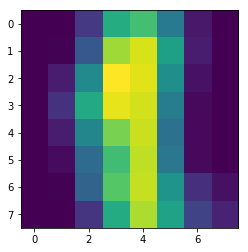

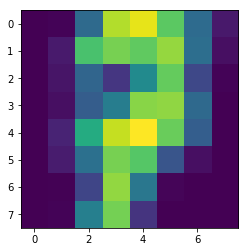

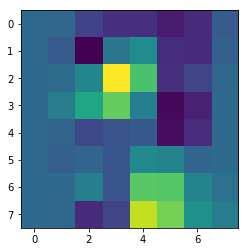

8.62046059409
17.5227719099


In [2]:
img1 = images17[target17 == 1].mean(axis=0)

img7 = images17[target17 == 7].mean(axis=0)

plt.figure()
plt.imshow(img1)
plt.figure()
plt.imshow(img7)
plt.figure()
plt.imshow(img1-img7)
plt.show()

print(images17[target17 == 1].var(axis=1).mean())
print(images17[target17 == 7].var(axis=1).mean())

In [3]:
def reduce_dim(x):
    feature1 = x
    feature1.shape = feature1.shape[0],8,8
    feature1 = feature1.var(axis=1).mean(axis=1) + feature1.var(axis=1).min(axis=1)
    
    feature2 = 0.7 * x[:,2,3] + 0.3 * x[:,7,4]
    
    return np.stack((feature1, feature2), axis=1)

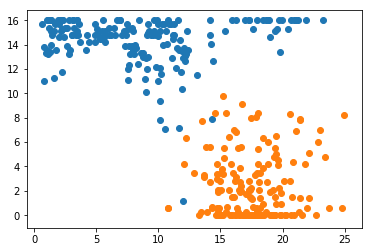

In [4]:
reduced_data = reduce_dim(data17)

plt.scatter(*reduced_data[target17 == 1].T)
plt.scatter(*reduced_data[target17 == 7].T)
plt.show()

# 2 Nearest Mean

In [5]:
classes = np.array((1,7))

def nearest_mean(training_features, training_labels, test_features):
    mean1 = training_features[training_labels == 1].mean(axis=0)
    mean7 = training_features[training_labels == 7].mean(axis=0)
    
    return classes[
        np.argmin(
            np.stack(
                (np.linalg.norm(mean1 - test_features, axis=1),
                 np.linalg.norm(mean7 - test_features, axis=1)),
                axis=1
            ),
            axis=1
        )
    ]

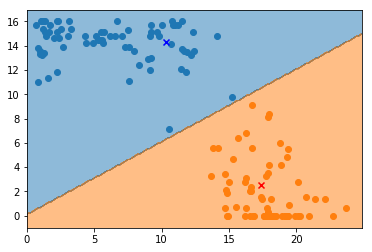

In [6]:
x = np.arange(0, 25, 25/200)
y = np.arange(-1, 17, 18/200)

xx, yy = np.meshgrid(x,y)

grid = np.column_stack((xx.flatten(), yy.flatten()))
grid_labels = nearest_mean(reduce_dim(train_data), train_target, grid)
grid_labels.shape = 200,200

reduced_train = reduce_dim(train_data)
reduced_test = reduce_dim(test_data)
predicted_labels = nearest_mean(reduce_dim(train_data),
                             train_target, reduced_test)

mean1 = reduced_train[train_target == 1].mean(axis=0)
mean7 = reduced_train[train_target == 7].mean(axis=0)

plt.contourf(xx, yy, grid_labels, alpha=0.5, colors=('C0','C1'))
plt.scatter(*reduced_test[predicted_labels==1].T)
plt.scatter(*reduced_test[predicted_labels==7].T)

plt.scatter(*mean1, marker='x', c='b')
plt.scatter(*mean7, marker='x', c='r')


plt.show()

# 3 QDA

In [7]:
def fit_qda(training_features, training_labels):
    means = np.stack(
        (training_features[training_labels == 1].mean(axis=0),
        training_features[training_labels == 7].mean(axis=0)),
        axis=0
    )
    
    covmat = np.stack(
        (np.cov(training_features[training_labels == 1].T),
        np.cov(training_features[training_labels == 7].T)),
        axis=0
    )
    
    priors = np.array(
        ((training_labels == 1).sum()/training_labels.shape[0],
         (training_labels == 7).sum()/training_labels.shape[0])
    )
    
    return means, covmat, priors

fit_qda(reduced_train, train_target)

(array([[ 10.3238783 ,  14.29174312],
        [ 17.38262996,   2.48504673]]), array([[[ 33.49647521,   0.70095202],
         [  0.70095202,   5.18261638]],
 
        [[  8.04208824,   1.56672779],
         [  1.56672779,   6.55052901]]]), array([ 0.50462963,  0.49537037]))

In [8]:
def predict_qda(mu, covmat, p, x):
    xx = x[:,np.newaxis,:]
    
    xmu = (xx - mu)
    return classes[
        np.argmin(
            np.sum(
                np.transpose(
                    np.dot(xmu,np.linalg.inv(covmat)).diagonal(axis1=1, axis2=2),
                    (0,2,1)
                ) * xmu,
                axis=-1
            ) + 0.5 * np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p),
            axis=1
        )
    ]

train_error = (predict_qda(*fit_qda(reduced_train, train_target),
                           reduced_train)!=train_target).sum()/train_target.shape[0]
test_error = (predict_qda(*fit_qda(reduced_train, train_target),
                           reduced_test)!=test_target).sum()/test_target.shape[0]
print("Training error: ", train_error)
print("Test error: ", test_error)

Training error:  0.0138888888889
Test error:  0.0137931034483


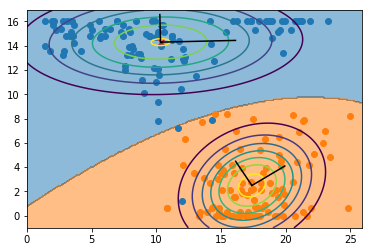

In [9]:
x = np.arange(0, 26, 26/200)
y = np.arange(-1, 17, 18/200)

xx, yy = np.meshgrid(x,y)
grid = np.column_stack((xx.flatten(), yy.flatten()))

means, covs, priors = fit_qda(reduced_train, train_target)

grid_labels = predict_qda(means, covs, priors, grid)
grid_labels.shape = 200,200

gaussian1 = multivariate_normal.pdf(grid, mean=means[0], cov=covs[0])
gaussian1.shape = 200,200
gaussian7 = multivariate_normal.pdf(grid, mean=means[1], cov=covs[1])
gaussian7.shape = 200,200

plt.contourf(xx, yy, grid_labels, alpha=0.5, colors=('C0','C1'))
plt.contour(xx, yy,gaussian1)
plt.contour(xx, yy,gaussian7)
plt.scatter(*reduced_train[train_target == 1].T)
plt.scatter(*reduced_train[train_target == 7].T)
plt.scatter(means[0,0], means[0,1], marker='x', c='r')

for mean, cov in zip(means, covs):
    w, v = np.linalg.eig(cov)
    plt.plot(*zip(mean,mean+np.sqrt(w[0])*v[:,0]),'k-')
    plt.plot(*zip(mean,mean+np.sqrt(w[1])*v[:,1]),'k-')

plt.show()

In [10]:
class QDA(sklearn.base.BaseEstimator,sklearn.base.ClassifierMixin):
    
    def fit(self, training_features, training_labels):
        self.means, self.covs, self.priors = fit_qda(training_features, training_labels)
        
    def predict(self, x):
        return predict_qda(self.means, self.covs, self.priors, x)
    
classifier = QDA()        
scores = cross_val_score(classifier, reduced_data, target17, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.98 (+/- 0.02)


# 4 LDA

In [11]:
def fit_lda(training_features, training_labels):
    means = np.stack(
        (training_features[training_labels == 1].mean(axis=0),
        training_features[training_labels == 7].mean(axis=0)),
        axis=0
    )
    
    covmat = np.sum(np.matmul((training_features[training_labels == 1] - means[0])[:,:,np.newaxis],
                    (training_features[training_labels == 1] - means[0])[:,np.newaxis,:]), axis=0)
    covmat += np.sum(np.matmul((training_features[training_labels == 7] - means[1])[:,:,np.newaxis],
                    (training_features[training_labels == 7] - means[1])[:,np.newaxis,:]), axis=0)    
    
    covmat /= training_features.shape[0]
    
    invcovmat = np.linalg.inv(covmat)
    
    w = np.matmul(invcovmat, means[:,:,np.newaxis])
    w = w[1] - w[0]
    
    priors = np.array(
        ((training_labels == 1).sum()/training_labels.shape[0],
         (training_labels == 7).sum()/training_labels.shape[0])
    )
    
    b = -0.5*np.matmul(np.matmul(means[:,np.newaxis,:], invcovmat), means[:,:,np.newaxis]).flatten() + np.log(priors)
    b = b[1] - b[0]
    
    return w, b, means, covmat

fit_lda(reduced_train, train_target)

(array([[ 0.45583162],
        [-2.12144235]]),
 11.462225913228773,
 array([[ 10.3238783 ,  14.29174312],
        [ 17.38262996,   2.48504673]]),
 array([[ 20.69481794,   1.11933317],
        [  1.11933317,   5.80591965]]))

In [12]:
def predict_lda(w, b, x):
    return classes[(np.matmul(w.T, x[:,:,np.newaxis]) + b > 0).flatten().astype(int)]
train_error = (predict_lda(*fit_lda(reduced_train, train_target)[:2],
                           reduced_train)!=train_target).sum()/train_target.shape[0]
test_error = (predict_lda(*fit_lda(reduced_train, train_target)[:2],
                           reduced_test)!=test_target).sum()/test_target.shape[0]
print("Training error: ", train_error)
print("Test error: ", test_error)

Training error:  0.0138888888889
Test error:  0.0206896551724


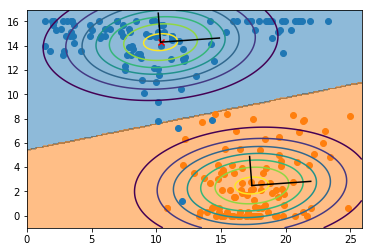

In [13]:
x = np.arange(0, 26, 26/200)
y = np.arange(-1, 17, 18/200)

xx, yy = np.meshgrid(x,y)
grid = np.column_stack((xx.flatten(), yy.flatten()))

w, b, means, cov = fit_lda(reduced_train, train_target)

grid_labels = predict_lda(w, b, grid)
grid_labels.shape = 200,200

gaussian1 = multivariate_normal.pdf(grid, mean=means[0], cov=cov)
gaussian1.shape = 200,200
gaussian7 = multivariate_normal.pdf(grid, mean=means[1], cov=cov)
gaussian7.shape = 200,200

plt.contourf(xx, yy, grid_labels, alpha=0.5, colors=('C0','C1'))
plt.contour(xx, yy,gaussian1)
plt.contour(xx, yy,gaussian7)
plt.scatter(*reduced_train[train_target == 1].T)
plt.scatter(*reduced_train[train_target == 7].T)
plt.scatter(means[0,0], means[0,1], marker='x', c='r')

for mean in means:
    w, v = np.linalg.eig(cov)
    plt.plot(*zip(mean,mean+np.sqrt(w[0])*v[:,0]),'k-')
    plt.plot(*zip(mean,mean+np.sqrt(w[1])*v[:,1]),'k-')

plt.show()

In [14]:
class LDA(sklearn.base.BaseEstimator,sklearn.base.ClassifierMixin):
    
    def fit(self, training_features, training_labels):
        self.w, self.b, _, _ = fit_lda(training_features, training_labels)
        
    def predict(self, x):
        return predict_lda(self.w, self.b, x)
    
classifier = LDA()        
scores = cross_val_score(classifier, reduced_data, target17, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.98 (+/- 0.03)
